In [1]:
import numpy
import numpy.linalg
import sklearn.datasets
from matplotlib import pyplot
import pandas as pd

In [2]:
def polyKernel(a, b, pwr):
    return numpy.dot(a, b) ** pwr  # numpy.dot(a,a) - numpy.dot(b,b) # -1 #


def rbfKernel(a, b, gamma):
    return numpy.exp(-gamma * numpy.linalg.norm(a - b))


In [3]:
class SimpleSVClustering:
    w = None
    a = None
    b = None
    C = None
    sv = None
    kernel = None
    kargs = ()
    tolerance = None
    verbose = False

    def __init__(self,
                 C,
                 tolerance=0.001,
                 kernel=numpy.dot,
                 kargs=()
                 ):
        """
        The parameters are:
         - C: SVC cost
         - tolerance: gradient descent solution accuracy
         - kernel: the kernel function do use as k(a, b, *kargs)
         - kargs: extra parameters for the kernel
        """
        self.C = C
        self.kernel = kernel
        self.tolerance = tolerance
        self.kargs = kargs

    def _checkClass(self, a, b, n_checks=5):
        """
        This does a straight line interpolation between a and b, using n_checks number of segments.
        It returns True if a and b are connected by a high probability region, false otherwise.
        NOTE: authors originally suggested 20 segments but that is SLOOOOOW, so we use 5. In practice it is pretty good.
        """
        for i in numpy.arange(1.0 / n_checks, 1.0, 1.0 / n_checks):
            if self._predict(i * a + (1 - i) * b) > self.b:
                return False
        return True
        # test = [bool(self._predict(i*a + (1-i)*b) <= self.b) for i in numpy.arange(1.0/n_checks,1.0,1.0/n_checks)]
        # return not False in test

    def _getAllClasses(self, X):
        """
        Assign class labels to each vector based on connected graph components.
        TODO: The outputs of this should really be saved in order to embed new points into the clusters.
        """

        # 1: build the connected clusters
        unvisited = range(len(X))
        clusters = []
        while len(unvisited):
            # create a new cluster with the first unvisited node
            c = [unvisited[0]]
            unvisited.pop(0)
            i = 0
            while i < len(c) and len(unvisited):
                # for all nodes in the cluster, add all connected unvisited nodes and remove them fromt he unvisited list
                unvisitedNew = []
                for j in unvisited:
                    (c if self._checkClass(X[c[i], :], X[j, :]) else unvisitedNew).append(j)
                unvisited = unvisitedNew
                i += 1
            clusters.append(c)

        # 3: group components by classification
        classifications = numpy.zeros(len(X)) - 1
        for i in xrange(len(clusters)):
            for c in clusters[i]:
                classifications[c] = i
        return classifications

    def fit(self, X):
        """
        Fit to data X with labels y.
        """

        """
        Construct the Q matrix for solving
        """
        Q = numpy.zeros((len(data), len(data)))
        for i in xrange(len(data)):
            for j in xrange(i, len(data)):
                Qval = 1.
                Qval *= self.kernel(*(
                        (data[i, :], data[j, :])
                        + self.kargs
                ))
                Q[i, j] = Q[j, i] = Qval

        """
        Solve for a and w simultaneously by coordinate descent.
        This means no quadratic solver is needed!
        The support vectors correspond to non-zero values in a.
        """
        self.w = numpy.zeros(X.shape[1])
        self.a = numpy.zeros(X.shape[0])
        delta = 10000000000.0
        while delta > self.tolerance:
            delta = 0.
            for i in xrange(len(data)):
                g = numpy.dot(Q[i, :], self.a) - Q[i, i]
                adelta = self.a[i] - min(max(self.a[i] - g / Q[i, i], 0.0), self.C)
                self.w += adelta * X[i, :]
                delta += abs(adelta)
                self.a[i] -= adelta
            if self.verbose:
                print
                "Descent step magnitude:", delta

        # get the data for support vectors
        Qshrunk = Q[self.a >= self.C / 100., :][:, self.a >= self.C / 100.]
        self.sv = X[self.a >= self.C / 100., :]
        self.a = (self.a)[self.a >= self.C / 100.]

        # Do an all-pairs contour check

        # calculate the contribution of all SVs
        for i in xrange(len(self.a)):
            for j in xrange(len(self.a)):
                Qshrunk[i, j] *= self.a[i] * self.a[j]

        # this is needed for radius calculation apparently
        self.bOffset = numpy.sum(numpy.sum(Qshrunk))
        if self.verbose:
            print
            "Number of support vectors:", len(self.a)

        """
        Select support vectors and solve for b to get the final classifier
        """
        self.b = numpy.mean(self._predict(self.sv))

        if self.verbose:
            print
            "Bias value:", self.b

    def _predict(self, X):
        """
        For SVClustering, we need to calculate radius rather than bias.
        """
        if (len(X.shape) < 2):
            X = X.reshape((1, -1))
        clss = numpy.zeros(len(X))
        for i in xrange(len(X)):
            clss[i] += self.kernel(*((X[i, :], X[i, :]) + self.kargs))
            for j in xrange(len(self.sv)):
                clss[i] -= 2 * self.a[j] * self.kernel(*((self.sv[j, :], X[i, :]) + self.kargs))
        return (clss + self.bOffset) ** 0.5

    def predict(self, X):
        """
        Predict classes for data X.
        NOTE: this should really be done with either the fitting data or a superset of the fitting data.
        """

        return self._getAllClasses(X)


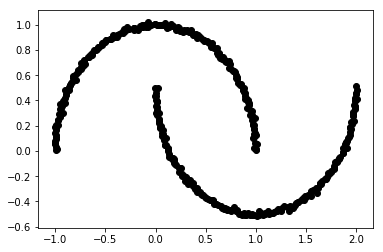

(400, 2)
<type 'numpy.ndarray'>


In [4]:
data, labels = sklearn.datasets.make_moons(400, noise=0.01, random_state=0)
pyplot.scatter(data[:,0],data[:,1],c='black')
pyplot.show()
data -= numpy.mean(data, axis=0)
print data.shape
print type(data)

In [5]:
 # parameters can be sensitive, these ones work for two moons
C = 0.1
clss = SimpleSVClustering(C, 1e-10, rbfKernel, (3.5,))
clss.fit(data)

# check assigned classes for the two moons as a classification error
t = clss.predict(data)
print
"Error", numpy.sum((labels - t) ** 2) / float(len(data))

('Error', 0.025)

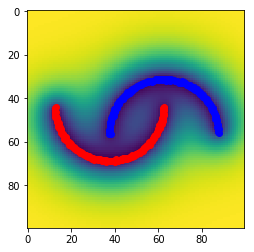

In [6]:
# generate a heatmap and display classified clusters.
a = numpy.zeros((100, 100))
for i in xrange(100):
    for j in xrange(100):
        a[j, i] = clss._predict(numpy.array([i * 4 / 100. - 2, j * 4 / 100. - 2]))
pyplot.imshow(a, cmap='viridis', interpolation='nearest')
data *= 25.
data += 50.
pyplot.scatter(data[t == 0, 0], data[t == 0, 1], c='r')
pyplot.scatter(data[t == 1, 0], data[t == 1, 1], c='b')

pyplot.show()